Imports


In [ ]:
!pip install ucimlrepo
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import kerastuner as kt
from ucimlrepo import fetch_ucirepo

<ipython-input-2-e36bd249444d>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)

# data (as pandas dataframes)
X = rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets

# metadata
print(rice_cammeo_and_osmancik.metadata)

# variable information
print(rice_cammeo_and_osmancik.variables)


{'uci_id': 545, 'name': 'Rice (Cammeo and Osmancik)', 'repository_url': 'https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik', 'data_url': 'https://archive.ics.uci.edu/static/public/545/data.csv', 'abstract': "A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 3810, 'num_features': 7, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5MW4Z', 'creators': [], 'intro_paper': {'ID': 276, 'type': 'NATIVE', 'title': 'Classification of Rice Varieties Using Artificial Intelligence Methods', 'authors': 'Ilkay Cinar, M. Koklu', 'venue': 'International Journal of Intel

In [ ]:
# Fetch dataset
rice = fetch_ucirepo(id=545)
X = rice.data.features
y = rice.data.targets

# Encode target labels
#Converts categories like "Cammeo" and "Osmancik" into integers (e.g., 0 and 1).
#Ensures the model interprets them as distinct classes rather than ordered values.

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.values.ravel())

# Apply PCA for feature selection

#Transforms features into a new set of uncorrelated variables (principal components).
#Ranks components by how much variance they capture.
#Selects fewer features that explain most of the data, improving model efficiency.

#Why it’s beneficial:
#Speeds up training: Fewer features mean faster computations.
#Reduces noise: Removes redundant or irrelevant features.
#Improves generalization: Less risk of overfitting with fewer dimensions.

pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [ ]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# Normalize features

# Faster Convergence: Gradient-based methods like backpropagation train faster with scaled features.
# Prevents Dominance: Without scaling, features with larger ranges can overshadow smaller ones.
# Improved Accuracy: Models perform better when features are on similar scales.

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Why hypertune?

Improves Model Performance: Finds hyperparameters that maximize accuracy and generalization.

✅ Saves Time & Effort: No need for manual trial-and-error.

✅ Efficient Resource Usage: Quickly identifies unpromising configurations.

✅ Flexible & Easy to Use: Integrates seamlessly with Keras models.



In [ ]:
# MLP Model Hyperparameter Tuning using KerasTuner

# KerasTuner is used to tune:
# Number of units in hidden layers (units_1, units_2)
# Dropout rates (dropout_1, dropout_2) to prevent overfitting
# Learning rate for the optimizer (learning_rate)

#Compiles with Adam optimizer and binary cross-entropy loss


def build_mlp(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(hp.Int('units_1', 32, 128, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))
    model.add(keras.layers.Dense(hp.Int('units_2', 16, 64, step=16), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Perform Hyperparameter Search
#Finds the best architecture and parameters for the MLP.
#Uses Hyperband to efficiently explore hyperparameter combinations.
#Stops early to prevent overfitting.

tuner = kt.Hyperband(build_mlp, objective='val_accuracy', max_epochs=20, factor=3, directory='my_dir', project_name='rice_mlp')
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Trial 30 Complete [00h 00m 14s]
val_accuracy: 0.9355300664901733

Best val_accuracy So Far: 0.9484240412712097
Total elapsed time: 00h 03m 46s


In [ ]:
# Train the best model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[early_stopping], verbose=1)

Epoch 1/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6070 - loss: 0.7335 - val_accuracy: 0.8871 - val_loss: 0.4235
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8387 - loss: 0.3753 - val_accuracy: 0.8990 - val_loss: 0.2637
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8815 - loss: 0.3039 - val_accuracy: 0.9016 - val_loss: 0.2292
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8771 - loss: 0.3015 - val_accuracy: 0.9055 - val_loss: 0.2195
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8919 - loss: 0.2643 - val_accuracy: 0.9121 - val_loss: 0.2130
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8862 - loss: 0.2805 - val_accuracy: 0.9094 - val_loss: 0.2108
Epoch 7/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9041 - loss: 0.2361 - val_accuracy: 0.9094 - val_loss: 0.2101
Epoch 8/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9012 - loss: 0.2455 - val_accu

In [ ]:
# Predictions and Evaluation
y_prob = model.predict(X_test)
best_threshold = 0.5  # Optionally, find the best threshold dynamically
y_pred = (y_prob > best_threshold).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       326
           1       0.93      0.93      0.93       436

    accuracy                           0.92       762
   macro avg       0.92      0.92      0.92       762
weighted avg       0.92      0.92      0.92       762



In [ ]:
# Predictions and Evaluation
y_prob = model.predict(X_test).flatten()
y_pred = np.round(y_prob, 2)  # Round predicted probabilities to 2 decimal places
y_pred_class = (y_prob > 0.5).astype(int)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Classification Report
report = classification_report(y_test, y_pred_class, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(2)  # Round all metrics to 2 decimal places
print("Classification Report (2 Decimal Places):\n", report_df)

Classification Report (2 Decimal Places):
               precision  recall  f1-score  support
0                  0.90    0.90      0.90   326.00
1                  0.93    0.93      0.93   436.00
accuracy           0.92    0.92      0.92     0.92
macro avg          0.92    0.92      0.92   762.00
weighted avg       0.92    0.92      0.92   762.00


In [ ]:
# Classification Report with Metrics as Percentages (2 Decimal Places)
report = classification_report(y_test, y_pred_class, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Convert metrics to percentages and round to 2 decimal places for readability
percentage_metrics = ['precision', 'recall', 'f1-score', 'support']
for metric in percentage_metrics:
    if metric in report_df.columns:
        if metric != 'support':
            report_df[metric] = (report_df[metric] * 100).round(2)  # Convert to % and round
        else:
            report_df[metric] = report_df[metric].round(0)  # Support remains as whole numbers

print("Classification Report (% with 2 Decimal Places):\n", report_df)

Classification Report (% with 2 Decimal Places):
               precision  recall  f1-score  support
0                 90.49   90.49     90.49    326.0
1                 92.89   92.89     92.89    436.0
accuracy          91.86   91.86     91.86      1.0
macro avg         91.69   91.69     91.69    762.0
weighted avg      91.86   91.86     91.86    762.0


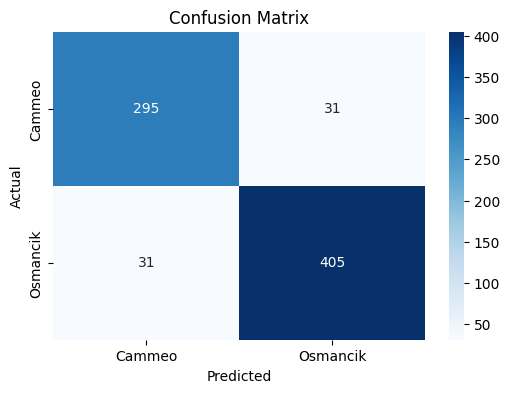

In [ ]:
# Display Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

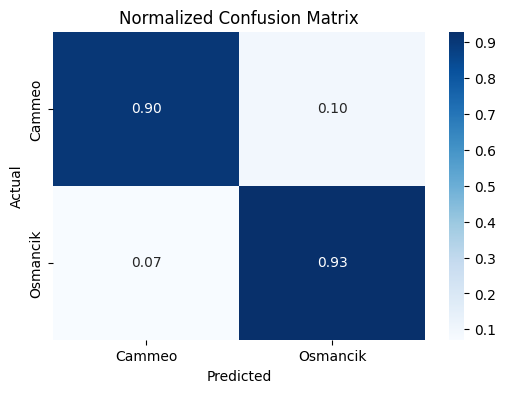

In [ ]:
# Compute and Display Normalized Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 4))
sns.heatmap(norm_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()


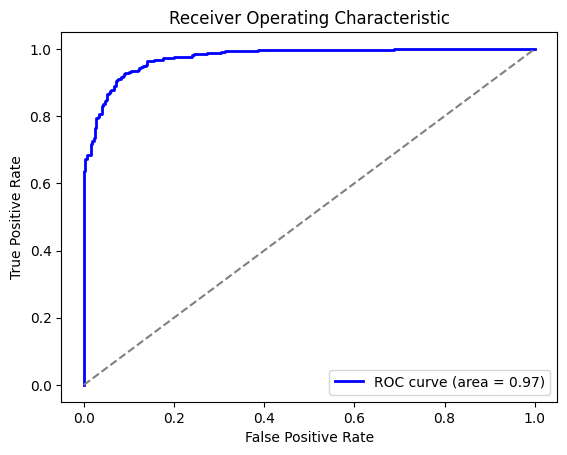

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

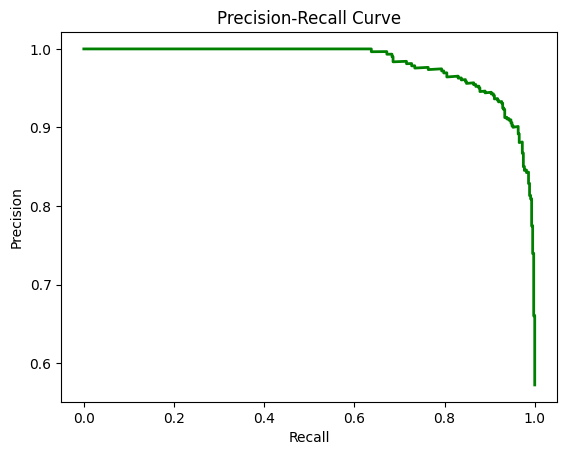

In [ ]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

ExactExplainer explainer: 763it [00:33, 22.41it/s]                         


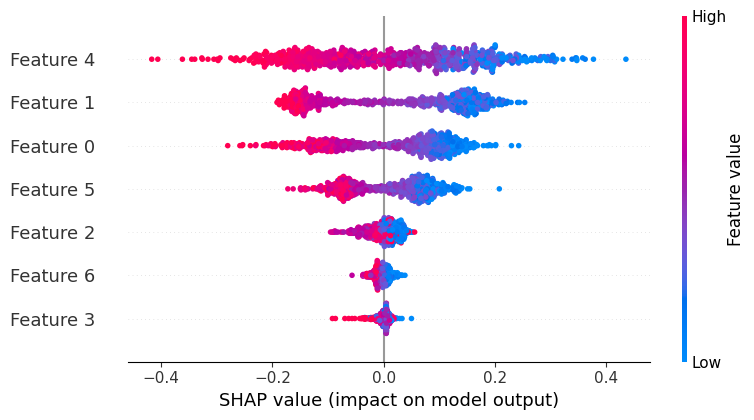

In [ ]:
# SHAP Feature Importance
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
